# Transition from Brunel to Potjans
## Analysis of simulations and mean field model

## Simulated transition

In [18]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)
import sim_params as sim; reload(sim)


%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

colors = style.colors

In [19]:
# DATA
data_path = "/export/data-schuessler/data_microcircuit/vary_d"
#sim_spec = "a0.1_t0.6_00"
#sim_spec = "a1.0_t5.2_00"
#sim_spec = "a1.0_t20.2_00" #look at different parameters! here sd_J02 ?=? 0
sim_spec = "a1.0_t20.2_02"
# Original data
data_file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"
path_data_file = os.path.join(data_path, data_file_name)
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_data_file)

### Plot results

## Mean field model

In [23]:
from scipy.optimize import root

def transition(model_init, model_final,  
               v_guess_0=np.array([110, 107, 122, 117, 120, 117, 141, 122]),
               step_init=0.01, d_step=0.5, tolerance=5,
               root_function='siegert',
               jacobian=False, root_method='hybr', options=None):
    """Iteratively solve consistency equation for v, starting at 
    model_init, changing towards model_final.

    Initial guess should not be too far off. Default for Brunel model A in 8D.
    
    Step size is adapted, starting with step_init, 
    adapting size with step *= d_step.
    Maximal number of step decreases = tolerance. 
    
    Further arguments:
    jacobian    ~ whether to use calculated jacobian
    root_method ~ method used by scipy.optimize.root
    options     ~ options for this method

    Returns distances, v0s[distance, population], failures, last model
    """
    # Instantiation
    if jacobian:
        jac = mf_net.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    if root_function=="siegert":
        sol = root(model_init.root_v0_siegert, v_guess_0, jac=jac, method=root_method, options=options)
    else:
        sol = root(model_init.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        print("intial success")
        v0  = sol["x"]
        if np.all(v0 < 1./model_init.t_ref): 
            v0s     = v0
            distances = [0]
            v_guess = v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
    
    # Define steps and matrices
    step    = step_init     # initial step size
    dist    = 0.
    n_fails = 0
    n_succ  = 0
    failures    = []

    # Looping
    while dist <= 1.:
        dist += step
    
        # New model
        area            = (1. - dist) * model_init.area         + dist * model_final.area        
        n_neurons       = (1. - dist) * model_init.n_neurons    + dist * model_final.n_neurons   
        C_ab            = (1. - dist) * model_init.C_ab         + dist * model_final.C_ab        
        j02             = (1. - dist) * model_init.j02          + dist * model_final.j02         
        g               = (1. - dist) * model_init.g            + dist * model_final.g           
        rate_ext        = (1. - dist) * model_init.rate_ext     + dist * model_final.rate_ext    
        weight_rel_sd   = (1. - dist) * model_init.weight_rel_sd   + dist * model_final.weight_rel_sd  
        delay_rel_sd    = (1. - dist) * model_init.delay_rel_sd + dist * model_final.delay_rel_sd
        model = model_class.model(area=area, 
                                         n_neurons=n_neurons, C_ab=C_ab, 
                                         connection_rule="fixed_indegree",
                                         j02=j02, g=g, rate_ext=rate_ext,
                                         weight_rel_sd=weight_rel_sd, 
                                         delay_rel_sd=delay_rel_sd) 
        try:
            if root_function=="siegert":
                sol = root(model.root_v0_siegert, v_guess, jac=jac, method=root_method, options=options)
            else:
                sol = root(model.root_v0, v_guess, jac=jac, method=root_method, options=options)
            if sol["success"]:
                v0  = sol["x"]
                if np.all(v0 < 1./model.t_ref): 
                    v0s = np.vstack((v0s, v0))
                    distances.append(dist)
                    v_guess = v0
                    n_fails = 0
                    n_succ  +=1
                    if n_succ >= tolerance and step < step_init:
                        print("succ\t%.5f\t%i %i"%(dist, n_succ, np.log(step)/np.log(d_step)))
                        step /= d_step
                else:       # converged unphysically (v0 >= 1/t_ref)
                    raise Exception("unphysical")
            else:   
                raise Exception("no solution")
        except: # no (good) solution found
            failures.append(dist)
            n_fails += 1
            n_succ   = 0
            print("fail\t%.5f\t%i %i"%(dist, n_fails, np.log(step)/np.log(d_step)))
            dist = distances[-1]
            step    *= d_step
            if n_fails >= tolerance:
                print("Tolerance exceeded at distance = %.3f"%dist)
                break
    distances = np.array(distances)
    failures  = np.array(failures)

    return(distances, v0s, failures, model)     


### Changed $C_{ab}$ and $J_{02}$

In [24]:
#######################################################
# Global boundaries
#######################################################
# Unchanged parameters
area            = 1.0
neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
g               = 4.0
rate_ext        = 8.0 # Hz background rate
weight_rel_sd   = 0.1
delay_rel_sd    = 0.0

# Brunel:
j02             = 1.0
weight_rel_sd   = 0.0
n_neurons       = "brunel"
C_ab            = "brunel"
model_brunel      = model_class.model(area=area, 
                                      neuron_model=neuron_model,
                                       n_neurons=n_neurons, C_ab=C_ab, 
                                       connection_rule=connection_rule,
                                       j02=j02, g=g, rate_ext=rate_ext,
                                       weight_rel_sd=weight_rel_sd, 
                                       delay_rel_sd=delay_rel_sd) 


# Microcircuit light:
# only some parameters like Potjans" model
# adapt n_neurons AND C_ab!
j02             = 2.0
weight_rel_sd   = 0.1
n_neurons       = "micro"
C_ab            = "micro"
model_micro       = model_class.model(area=area, 
                                      neuron_model=neuron_model,
                                      n_neurons=n_neurons, C_ab=C_ab, 
                                      connection_rule=connection_rule,
                                      j02=j02, g=g, rate_ext=rate_ext,
                                      weight_rel_sd=weight_rel_sd, 
                                      delay_rel_sd=delay_rel_sd) 


model_init      = model_brunel
model_final     = model_micro
v_guess_0       = np.array([110, 107, 122, 117, 120, 117, 141, 122])
d_step      = 0.1   # ratio by which step is reduced
step_init   = d_step**3  # initial step size
tolerance   = 5     # number of fails accepted at one distance
root_function = None
jacobian= None
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}


t_int0      = time.time()
dists, v0s, fails, last_model = transition(model_init, model_final, 
                                           v_guess_0, step_init, d_step, tolerance,
                                           root_function, jacobian, root_method, options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

intial success
Integration time: 34.48


In [26]:
######################################################
# Simulation results
######################################################
with h5py.File(os.path.join(data_path, data_file_name), "r") as data_file:
    dists_sim = data_file.attrs["dists"][:]

with h5py.File(os.path.join(data_path, res_file_name), "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    rates_std_all = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        print(sim_spec2)
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"]
        rates_std_all[j]    = res_grp["rates_std"]

d0.10_j1.10_sdJ0.00
d0.15_j1.15_sdJ0.00
d0.20_j1.20_sdJ0.00
d0.25_j1.25_sdJ0.00
d0.30_j1.30_sdJ0.00
d0.35_j1.35_sdJ0.00
d0.40_j1.40_sdJ0.00
d0.45_j1.45_sdJ0.00
d0.50_j1.50_sdJ0.00
d0.55_j1.55_sdJ0.00
d0.60_j1.60_sdJ0.00
d0.65_j1.65_sdJ0.00
d0.70_j1.70_sdJ0.00
d0.75_j1.75_sdJ0.00
d0.80_j1.80_sdJ0.00
d0.85_j1.85_sdJ0.00
d0.90_j1.90_sdJ0.00
d0.95_j1.95_sdJ0.00
d1.00_j2.00_sdJ0.00


save figure to transition_mf_vs_model


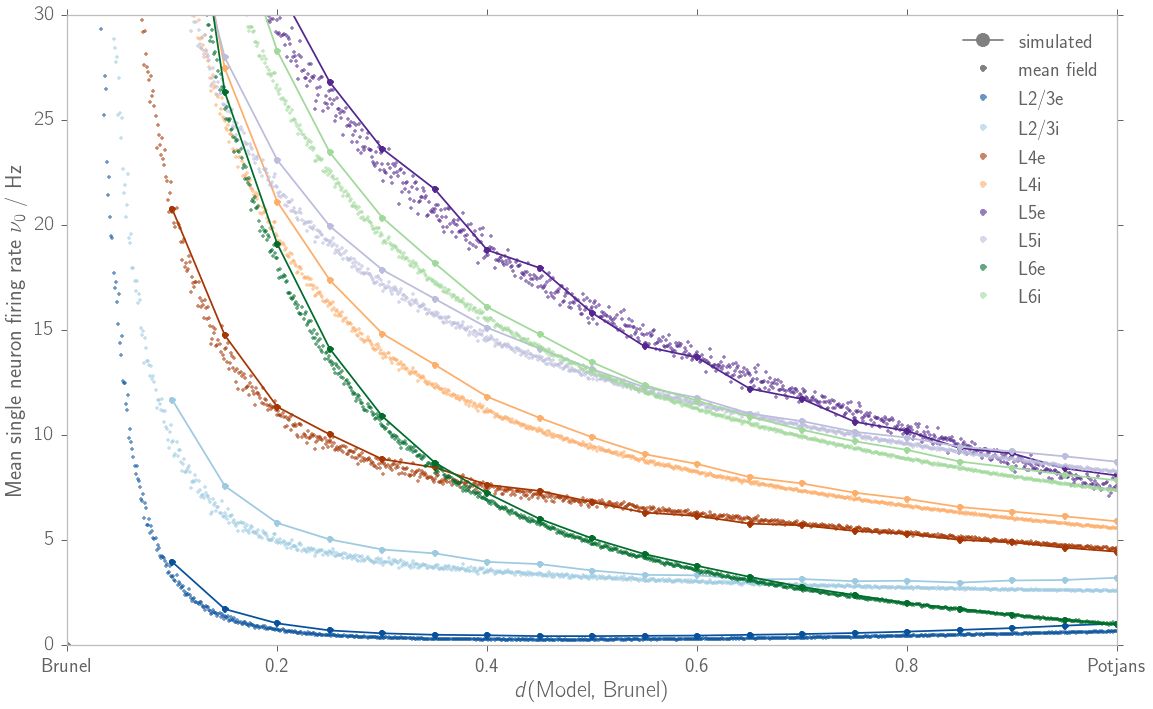

In [27]:
######################################################
# Plotting
######################################################
plot_pops=np.array(['L4e', 'L4i'])
plot_pops= last_model.populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])
i_pop  = np.array([np.where(plot_pop == last_model.populations)[0][0] 
                   for plot_pop in plot_pops])

fig = plt.figure()

ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

ax.plot([0, 0], [0, -1], 'o-', color="gray", label="simulated")
ax.plot([0, 0], [0, -1], '.', color="gray", label="mean field")
for i, population in zip(i_pop, plot_pops):
    ax.plot(dists, v0s[:, i], '.', color=colors[i], alpha=0.6,
        label=hf.rlbl(population))
    ax.plot(dists_sim, rates_mean_all[:, ::-1][:, i], 'o-', color=colors[i])
    
ax.set_xlim(0, min(1.0, dists[-1]*1.1))
ax.set_xlabel("$d(\mathrm{Model},\, \mathrm{Brunel})$")
ax.set_ylabel("Mean single neuron firing rate $\\nu_0$ / Hz")
ax.set_ylim(0, 30)
#ax.set_yscale("log")
ax.grid(False)
ax.legend(loc="best", markerscale=2)

xticks = np.linspace(0, 1, 6)
xticklabels = list(xticks)
xticklabels[0] = "Brunel"
xticklabels[-1] = "Potjans"
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

fig_name = "transition_mf_vs_model"
    
if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
    fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  

In [29]:
v0s[-1]

array([ 0.57178742,  2.5026658 ,  3.99233082,  5.55312084,  8.18822028,
        8.01927828,  1.62032298,  7.5922435 ])

### Raster plot and rates for each simulation

d0.10_j1.10_sdJ0.00
d0.15_j1.15_sdJ0.00
d0.20_j1.20_sdJ0.00
d0.25_j1.25_sdJ0.00
d0.30_j1.30_sdJ0.00
d0.35_j1.35_sdJ0.00
d0.40_j1.40_sdJ0.00
d0.45_j1.45_sdJ0.00


KeyboardInterrupt: 

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


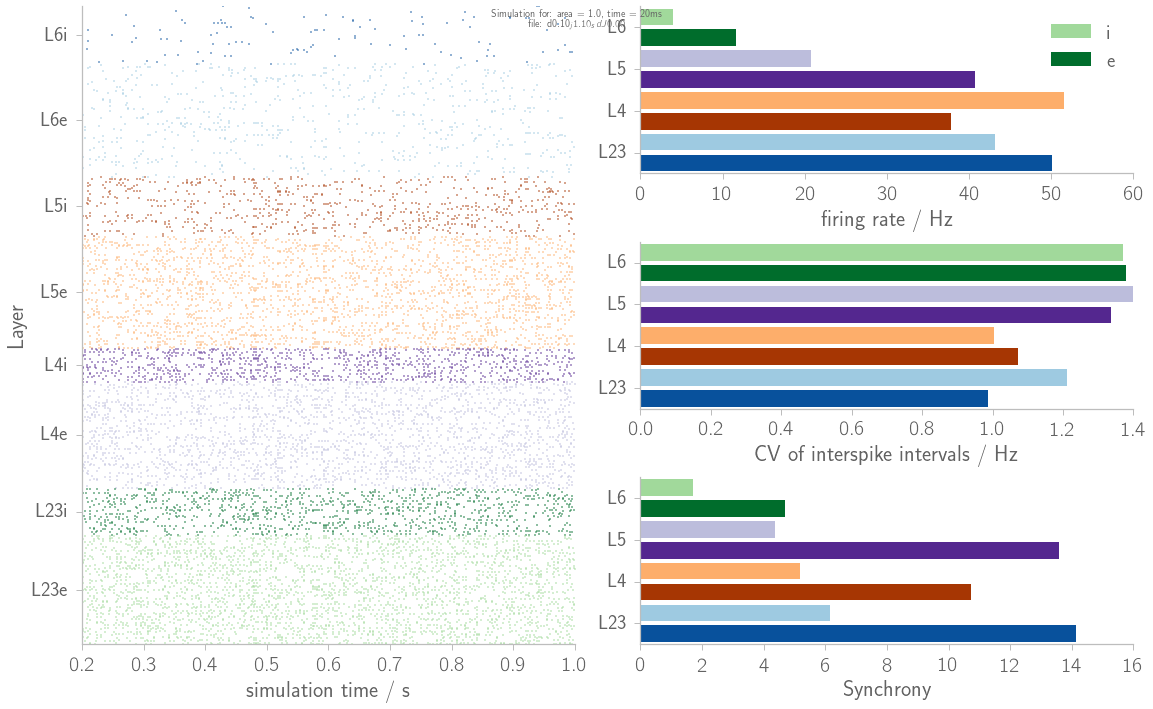

RuntimeError: LaTeX was not able to process the following string:
b'file: d0.15_j1.15_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./ed6ddaa10fb46e9ea4bce3cd107f4c11.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file ed6ddaa10fb46e9ea4bce3cd107f4c11.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.15_
                                                  j1.15_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.15_j1.15_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./ed6ddaa10fb46e9ea4bce3cd107f4c11.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on ed6ddaa10fb46e9ea4bce3cd107f4c11.dvi (1 page, 432 bytes).
Transcript written on ed6ddaa10fb46e9ea4bce3cd107f4c11.log.


RuntimeError: LaTeX was not able to process the following string:
b'file: d0.20_j1.20_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./43d24fcef2cb9d4cc5555de3a5bc2057.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 43d24fcef2cb9d4cc5555de3a5bc2057.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.20_
                                                  j1.20_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.20_j1.20_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./43d24fcef2cb9d4cc5555de3a5bc2057.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 43d24fcef2cb9d4cc5555de3a5bc2057.dvi (1 page, 432 bytes).
Transcript written on 43d24fcef2cb9d4cc5555de3a5bc2057.log.


RuntimeError: LaTeX was not able to process the following string:
b'file: d0.25_j1.25_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./b4a0124f5814a4b609a5e1090fc3b3eb.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file b4a0124f5814a4b609a5e1090fc3b3eb.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.25_
                                                  j1.25_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.25_j1.25_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./b4a0124f5814a4b609a5e1090fc3b3eb.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on b4a0124f5814a4b609a5e1090fc3b3eb.dvi (1 page, 432 bytes).
Transcript written on b4a0124f5814a4b609a5e1090fc3b3eb.log.


RuntimeError: LaTeX was not able to process the following string:
b'file: d0.30_j1.30_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./1ac7167f84f8cef1d5691d19adb3a4e2.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 1ac7167f84f8cef1d5691d19adb3a4e2.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.30_
                                                  j1.30_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.30_j1.30_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./1ac7167f84f8cef1d5691d19adb3a4e2.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 1ac7167f84f8cef1d5691d19adb3a4e2.dvi (1 page, 432 bytes).
Transcript written on 1ac7167f84f8cef1d5691d19adb3a4e2.log.


RuntimeError: LaTeX was not able to process the following string:
b'file: d0.35_j1.35_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./4ff2b37d603109b2c70403151d67ee5d.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 4ff2b37d603109b2c70403151d67ee5d.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.35_
                                                  j1.35_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.35_j1.35_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./4ff2b37d603109b2c70403151d67ee5d.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 4ff2b37d603109b2c70403151d67ee5d.dvi (1 page, 432 bytes).
Transcript written on 4ff2b37d603109b2c70403151d67ee5d.log.


RuntimeError: LaTeX was not able to process the following string:
b'file: d0.40_j1.40_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./1189185cbefee16eee4dc51287125bc8.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 1189185cbefee16eee4dc51287125bc8.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.40_
                                                  j1.40_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.40_j1.40_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./1189185cbefee16eee4dc51287125bc8.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 1189185cbefee16eee4dc51287125bc8.dvi (1 page, 432 bytes).
Transcript written on 1189185cbefee16eee4dc51287125bc8.log.


RuntimeError: LaTeX was not able to process the following string:
b'file: d0.45_j1.45_sdJ0.00'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./cb507144e3f755ea1e34af694dbef458.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file cb507144e3f755ea1e34af694dbef458.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ....000000}{12.500000}{\sffamily file: d0.45_
                                                  j1.45_sdJ0.00}
(/usr/share/texmf/tex/latex/cmbright/ot1cmbr.fd)
! Extra }, or forgotten $.
l.12 ...0000}{\sffamily file: d0.45_j1.45_sdJ0.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./cb507144e3f755ea1e34af694dbef458.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on cb507144e3f755ea1e34af694dbef458.dvi (1 page, 432 bytes).
Transcript written on cb507144e3f755ea1e34af694dbef458.log.


In [8]:
# Open file: results
res_file = h5py.File(os.path.join(data_path, res_file_name), "r")

# PLOTTING
for sim_spec2 in res_file.keys():  
    print(sim_spec2)
    res_grp = res_file[sim_spec2]
    res_raster = res_grp["raster"]
    
    rates_mean   = res_grp["rates_mean"]
    rates_std    = res_grp["rates_std"]
    cv_isi_mean  = res_grp["cv_isi_mean"]
    cv_isi_std   = res_grp["cv_isi_std"]
    synchrony    = res_grp["synchrony"]
    
    fig = plt.figure()
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec2
    
    fig.suptitle(suptitle, y=0.98)
    # Raster plot
    ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=3)
    # Rates
    ax1 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
    # CV of interspike interval (ISI)
    ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
    # Synchrony
    ax3 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)    
    
    y_mean = np.arange(n_populations) + 0.1
    bar_height = 0.8 
    for i, population in enumerate(populations):
        res_raster_pop = res_raster[str(population)]
        for times, neuron_ids in res_raster_pop.values():
            ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
        ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax3.barh(y_mean[i], synchrony[i],   height=bar_height, color=colors[i], linewidth=0)    
      

    # Raster Plot
    t_min_raster = res_raster.attrs["t_min_raster"]
    t_max_raster = res_raster.attrs["t_max_raster"]
    ymax_raster = res_raster.attrs["ymax_raster"]
    yticks = res_raster.attrs["yticks"]
    
    xlim = (t_min_raster, t_max_raster)
    ylim = (0, ymax_raster)
    ax0.set_yticks(yticks)
    ax0.set_yticklabels(populations)
    ax0.set_xlabel('simulation time / s')
    ax0.set_ylabel('Layer')
    ax0.set_xlim(*xlim)
    ax0.set_ylim(*ylim)
    ax0.grid(False)
      
    # Rates
    ax1.set_xlabel('firing rate / Hz')
    # CV of ISI
    ax2.set_xlabel('CV of interspike intervals / Hz')
    # Synchrony
    ax3.set_xlabel('Synchrony')
    
    ylim_mean = (0, n_populations)
    yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)
    for ax in (ax1, ax2, ax3):
        #ax.set_ylabel('Layer')
        ax.set_yticks(yticks_mean)
        ax.set_yticklabels(layers)
        ax.set_ylim(*ylim_mean)
        ax.grid(False)
    
    # Legend; order is reversed, such that labels appear correctly
    for i in range(n_types):
        ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
    ax1.legend(loc='best')
    
    for ax in fig.axes:
        style.fixticks(ax)
    fig_name = "cell_activity_" + sim_spec + "_" + sim_spec2
    
    save_fig2 = False
    if save_fig2:
        print("save figure to " + fig_name)
        fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
        fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  
    
res_file.close()